**Alternative version of Nearest Nighbour Classifier**

In this code, we implement one nearest neighbour classifier on CIFAR-10 Dataset and calculate its efficiency.

https://www.cs.toronto.edu/~kriz/cifar.html



In [1]:
import pickle
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from random import random



def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

datadict_tst = unpickle(r'/cifar-10/test_batch') #Loads all unpickled raw Test data in datadict_tst variable

labeldict = unpickle(r'/cifar-10/batches.meta')
label_names = labeldict["label_names"]

def Load_Data(Data_sets):
    LBL=[]
    for i in range(1, Data_sets+1):

        path='/cifar-10/data_batch_{}'.format(i)
        Load = unpickle(r'{}'.format(path))
        DAT=Load["data"]           
        LBL+=Load["labels"]
        if i == 1:           
            Da=Load["data"]           
        else:
            Da=np.vstack([Da, DAT])           
#    print("Data Shape:",Da.shape)
    LBL = np.array(LBL)
#    print("Label Shape:",LBL.shape)
    return Da,LBL


X,Y=Load_Data(5) #Load All 5 data sets into X1 and Labels in Y
X = X.astype("int32") #Reshape the 10K images into 3072. (Flattened)

Q1a = datadict_tst["data"]
Q_Label = datadict_tst["labels"]

Q_TST = Q1a.astype("int32") #Reshape the 10K images into 3072. (for RGBs)  
Q_Label = np.array(Q_Label)  ## contains class numbers for each image to tell which img belongs to which class

print('All Datasets Loaded')
print("Dataset's Dimensions:" ,X.shape)
print("Test Dataset's Dimensions:" ,Q_TST.shape)

print('========================================================================')



All Datasets Loaded
Dataset's Dimensions: (50000, 3072)
Test Dataset's Dimensions: (10000, 3072)


The Information in **X[0]** is given as a single vector of 3072. The color information is encoded as all reds together, all greens together and all blues together. so, 3 images of red,green,blue (3,32,32), we transpose it and re-arrange the channels to get correct image in order of (32,32,3)

Shape before:  (3072,)
Shape after:  (32, 32, 3)


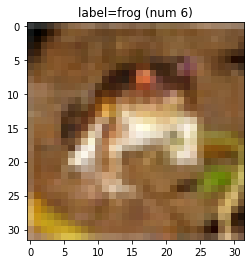

In [2]:
lbl=Y[0]
print("Shape before: ", X[0].shape)
img=X[0].reshape(3,32,32).transpose(1,2,0)  #0 - channels at last, 1 - 32 width first, 2 - 32 height second, total (32,32,3)
print("Shape after: ", img.shape)
plt.title(f"label={label_names[lbl]} (num {lbl})")
plt.imshow(img)

Define Random classifier and accuracy calculation function.

Random classifier will randomly try to guess the classes of the test dataset. Considering we have 10 classes, the random classifier has at best 10% chance of correctly classifying the images. So, anything we build has to be better than 10% baseline to be considered as better.

In [3]:
def class_acc(pred,gt): #This function will compare the Labels that were predicted using any 
                        #classifier (such as Random or 1NN) to Original labels that came with dataset (our ground truth)
                        #and will give us an accuracy estimate of our program.
    err=0            #will store number of mismatches
    accuracy=0          #wil be used to calculate accuracy
    for i in range(0,len(gt)): #Loop to iterate through all ground truth variables and compare with pred.
        if gt[i]!=pred[i]:     #comparing each Pred label to gt label
            err=err+1;         #increment the error counter

    accuracy=(len(pred)-err)/(len(pred)) #calculate the accuracy ((totalpts-error)/totalpts)*100(for %)
    accuracyPercentage=accuracy*100
    return accuracyPercentage

def cifar10_classifier_random(x): #This function will generate random label values from 0 to 9 for the given dataset.
    Rand_labels=np.array([])
    #print("=========== CALLING FUNC. cifar10_classifier_random Random Labels generator ===========")
    
    for i in range(0,len(x)): #Runs a loop from 0 to the length of your dataset
        Rand_label_val=randint(0, 9) #generates a list of random labels for that dataset. 
        Rand_labels = np.append(Rand_labels,Rand_label_val)
        
    #print("Predicted Label's Dimensions: ",Rand_labels.shape) #verify the shape of predicted labels
    return Rand_labels                                      #return predicted variables.




**Random Classifier Accuracy**

In [4]:
Values=cifar10_classifier_random(X)  #Function predicts and returns an array full of Random Labels.
Acc=class_acc(Values,Y) #Function Evaluates the Predicted labels and Actual labels to calculate the Accuracy %.
print("Random Classifier Accuracy for Predicted Labels in %: ",Acc)

Random Classifier Accuracy for Predicted Labels in %:  9.908


**Nearest Neighbor Classifier**

In [16]:
def Batch_ONN(X_train, Y_train, Query_points, batch_size=4):
    output=[]
    if len(Query_points) < batch_size:
        batch_size = len(Query_points)
        
    for i in range(0,len(Query_points),batch_size):
        Q_TP = Query_points[i:batch_size+i]  #Select a small subset of query points array to get their labels.

        dst = np.linalg.norm(Q_TP[:, np.newaxis]-X_train, axis=2)  #calc. euclidean dist for whole array.

        Y_Tile = np.tile(Y_train,(dst.shape[0],1)) #create multiple pairs of labels to attach with distances 

        dist_values = np.array((dst,Y_Tile)).transpose(1,2,0)  #Attach labels to distances

        dist_values_min = np.argmin(dist_values, axis=1).transpose()[0] #Select minimum distances for each query image

        #Access label values and store in output.
        idx = np.arange(0,len(dist_values_min))                         
        dist_values_min2 = np.array((idx, dist_values_min)).transpose()
        dist_values_min2 = tuple(map(tuple, dist_values_min2))

        #Access label values stored in tuple coordinates one by one. Max fetchable values will be equal to the batch size.
        for j in dist_values_min2:       
            data_label = dist_values[j]
            output.append(data_label[1])

    output=np.array(output)
    return output

In [18]:
%%timeit -r 1 -n 1
#Running on small subset of data
Q_TST2=Q_TST[:20]
Q_Label2=Q_Label[:20]

BATCH = Batch_ONN(X,Y,Q_TST2,1) #Function predicts and returns an array full of Labels by 1NN Classifier.
BATCH_Acc = class_acc(BATCH,Q_Label2)      #Calculate accuracy % of this TEST dataset by 
                                        #Comparing Predicted Labels to Ground truth labels (Actual Test Labels 10K in total)
print("1-NN Classifier Accuracy for Predicted Labels in %: ",BATCH_Acc)

1-NN Classifier Accuracy for Predicted Labels in %:  100.0
31.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
